In [1]:
from matplotlib import pyplot as plt
from matplotlib import animation

import networkx as nx
import numpy as np
import numpy.ma as ma
import pandas as pd

In [67]:
class Trial:
    def __init__(
        self,
        A, # adjacency matrix
        N,
        M,
        n_trials,
        memory_length,
        seed
    ):
        self.A = A
        self.N = N
        self.M = M
        self.n_trials = n_trials
        self.memory_length = memory_length
        self.rng = np.random.default_rng(seed)

        # minimum number of friends who went last time if it wasn't full
        self.alphas = np.ones((N, n_trials), dtype=int) * 2 
        # minimum number of friends who went last time if it was too full
        self.betas = np.ones((N, n_trials), dtype=int) * 5
        # weeks back to look when making decision
        self.gammas = np.ones((N, n_trials), dtype=int) * -1
        # random probability of going
        self.epsilons = np.ones((N, n_trials)) * 0.03
        # self.epsilons = np.ones((N, n_trials)) * 0
        # random probability of not going
        # nonzero delta could completely destabilize an arrangement
        # I think?
        self.deltas = np.zeros((N, n_trials)) 

        # each node needs to remember the last k weeks
        # options- we could target interventions to particular 
        # circumstances, e.g. reduce minfriends if you are never going
        # or we could just let things evolve randomly
        # let's start with random because yolo
        self.memory = np.full((N, memory_length), np.nan)

        # initial conditions
        self.Xnp = np.full((N, n_trials), np.nan)


        # track previous weeks' neighbor counts to avoid
        # redoing multiplication
        self.nc = np.full((N, n_trials), np.nan)
    
    
    def apply_thresholds(self, params, mask, X):
        #print("X: ")
        #print(X)
        for p in np.unique(params[:, self.t]):
            #print(p)
            mask = np.intersect1d(mask, np.where(params[:,self.t] == p))
            #print(len(mask))
            X[mask] = self.nc[mask, self.t] > p
            #print("New X: ")
            #print(X)
        return X
    
    
    def run(self):
        # initial conditions
        X = self.rng.uniform(size=(self.N,)) < 0.3
        self.Xnp[:,0] = X
        self.nc[:,0] = self.A.dot(X)
        
        self.t = 0
        
        while self.t < self.n_trials-1:

            # run backward computation for each gamma value
            for gamma in np.unique(self.gammas[:, self.t]):
                mask = np.where(self.gammas[:, self.t] == gamma)[0]

                if X.sum() < self.M:
                    X = self.apply_thresholds(self.alphas, mask, X)
                else:
                    X = self.apply_thresholds(self.betas, mask, X)

            # add noise
            X += self.rng.uniform(size=self.N) < self.epsilons[:,self.t]
            X = np.bitwise_and(X, self.rng.uniform(size=self.N) > self.deltas[:,self.t])

            self.t += 1
            # save this week's atttendance
            self.Xnp[:,self.t] = X
            # save number of neighbors that went this week
            self.nc[:,self.t] = self.A.dot(X)
            
            
    def plot_attendance(self):
        plt.plot(T.Xnp.sum(axis=0))

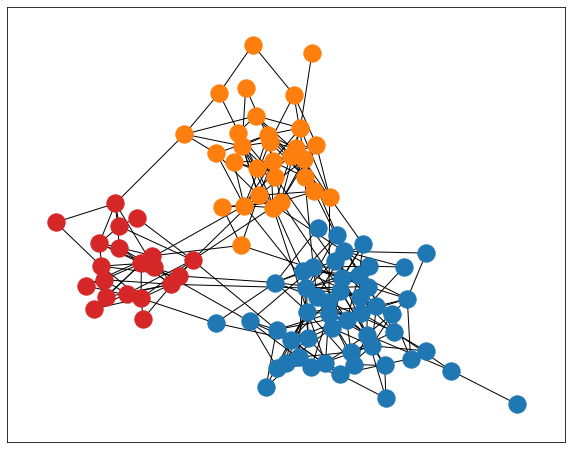

In [61]:
plt.rcParams["figure.figsize"] = (10,8)

sizes = [20, 50, 30]
probs = [[0.25,0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 1/6]]
G = nx.stochastic_block_model(sizes, probs, seed=30)
A = nx.convert_matrix.to_numpy_matrix(G)

pos = nx.spring_layout(G, seed=3113794652)
nx.draw_networkx_nodes(G, pos, nodelist=range(0,sizes[0]), node_color="tab:red")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0], sizes[0]+sizes[1]), node_color="tab:blue")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0]+sizes[1], 100), node_color="tab:orange")
nx.draw_networkx_edges(G, pos)

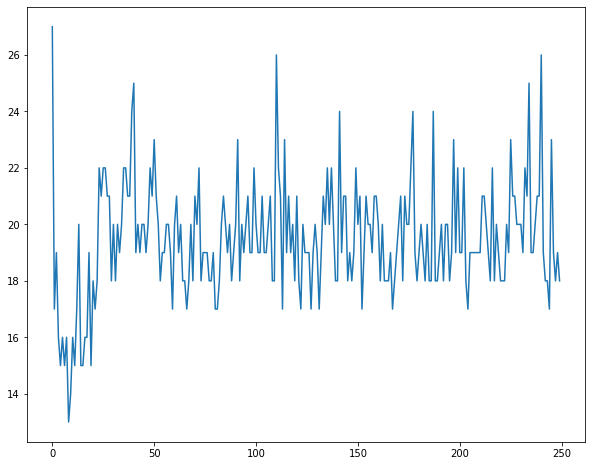

In [68]:
T = Trial(A, 100, 60, 250, 10, 1234567)
T.run()
T.plot_attendance()

In [72]:
# TODO sanity check
t = 73

T.Xnp[:,t]

array([1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [75]:
X_det = T.nc[:,t-1] > T.alphas[:,t-1]
T.Xnp[:,t] - X_det

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
eps = []
for t in range(1,250):
    X_det = T.nc[:,t-1] > T.alphas[:,t-1]
    eps.append((T.Xnp[:,t] - X_det).sum())
    
np.array(eps).mean()

2.4578313253012047

In [79]:
np.array(eps).plot(kind="")

2.4578313253012047

In [28]:
# TODO: configuration model